# **Multimodal ML Housing Price Prediction**

### **Install Libraries**

In [1]:
%pip install numpy pandas scikit-learn opencv-contrib-python tensorflow


  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-win_amd64.whl (45.3 MB)
Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl (12.6 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [numpy]
   ---------------------------------------- 0/2 [

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.3 which is incompatible.


### **Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate


### **Load and Clean Structured Data**

In [2]:
def load_structured_data(path):
    cols = ["bed", "bath", "area", "zip", "price"]
    df = pd.read_csv(path, sep=" ", header=None, names=cols)

    # Filter low-sample zipcodes
    zip_counts = df["zip"].value_counts()
    df = df[df["zip"].isin(zip_counts[zip_counts >= 25].index)]

    df["log_price"] = np.log1p(df["price"])
    return df

df = load_structured_data("Dataset/HousesInfo.txt")


### **Tabular Preprocessing**

In [3]:
def process_tabular(df, train_idx, test_idx):
    cont_cols = ["bed", "bath", "area"]

    scaler = MinMaxScaler()
    train_cont = scaler.fit_transform(df.loc[train_idx, cont_cols])
    test_cont = scaler.transform(df.loc[test_idx, cont_cols])

    lb = LabelBinarizer().fit(df["zip"])
    train_zip = lb.transform(df.loc[train_idx, "zip"])
    test_zip = lb.transform(df.loc[test_idx, "zip"])

    return (
        np.hstack([train_cont, train_zip]),
        np.hstack([test_cont, test_zip])
    )


### **Load and Stack House Images**

In [4]:
def load_cnn_input(df, base_dir, size=64):
    image_data = []

    for i in df.index.values:
        img_paths = sorted(glob.glob(os.path.join(base_dir, f"{i+1}_*.jpg")))
        if len(img_paths) < 4:
            continue
        imgs = [cv2.resize(cv2.imread(p), (size, size)) for p in img_paths]
        stacked = np.stack(imgs, axis=0)  # Shape: (4, 64, 64, 3)
        image_data.append(stacked)

    return np.array(image_data)


### **Split and Prepare Features**

In [5]:
# Split
train_idx, test_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Tabular
X_train_tab, X_test_tab = process_tabular(df, train_idx, test_idx)

# CNN Input: shape (num_houses, 4, 64, 64, 3)
X_img_all = load_cnn_input(df, "Dataset/")
X_train_img = X_img_all[:len(train_idx)]
X_test_img = X_img_all[len(train_idx):]

# Target
y_train = df.loc[train_idx, "log_price"].values
y_test = df.loc[test_idx, "log_price"].values


### **CNN Feature Extractor (Shared)**

In [6]:
def build_image_feature_extractor():
    inp = Input(shape=(64, 64, 3))
    x = Conv2D(16, (3,3), activation='relu')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    return Model(inp, x, name="CNN_FeatureExtractor")


### **Multimodal Model**

In [7]:
def build_multimodal_model(tabular_dim):
    cnn_extractor = build_image_feature_extractor()

    # 4 room images → 4 parallel CNNs → concat
    img_input = Input(shape=(4, 64, 64, 3))
    cnn_features = tf.keras.layers.TimeDistributed(cnn_extractor)(img_input)
    img_feat = Flatten()(cnn_features)  # Or use GlobalAveragePooling1D()

    tab_input = Input(shape=(tabular_dim,))
    merged = Concatenate()([img_feat, tab_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(64, activation='relu')(x)
    out = Dense(1)(x)

    return Model(inputs=[img_input, tab_input], outputs=out)

model = build_multimodal_model(X_train_tab.shape[1])
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 4, 64, 64, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4, 64)     │    406,560 │ input_layer_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 266)       │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     34,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 449,057 (1.71 MB)

 Trainable params: 449,057 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

### **Train Model**

In [17]:
history = model.fit(
    [X_train_img, X_train_tab], y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=8
)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0039 - val_loss: 2.0320
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0034 - val_loss: 1.9533
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0072 - val_loss: 2.0867
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0263 - val_loss: 2.1333
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0649 - val_loss: 2.1144
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1815 - val_loss: 1.8557
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.2477 - val_loss: 1.8258
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.3088 - val_loss: 2.5048
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3069 - val_loss: 2.1934
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2736 - val_loss: 1.9855
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.2431 - val_loss: 2.5182
Epoch 12/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3

### **Evaluate MAE and RMSE**

In [18]:
# Predict and transform back
y_pred_log = model.predict([X_test_img, X_test_tab]).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
MAE: $707,048.67
RMSE: $1,564,338.90


### **Prediction Visualization**

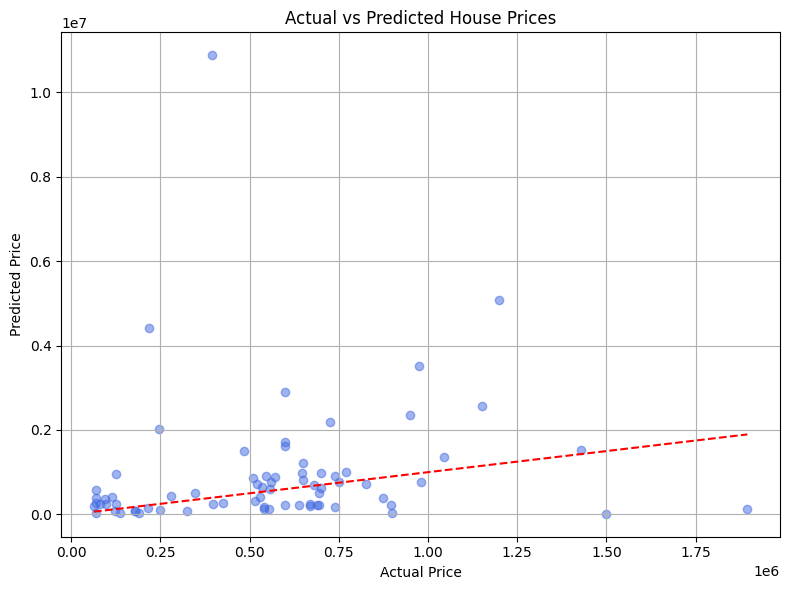

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.tight_layout()
plt.show()
